# Random Forest para Classificação do Jogo da Velha

Este notebook implementa um modelo Random Forest para classificar estados do jogo da velha 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier,plot_tree
import warnings
warnings.filterwarnings('ignore')

# Configuração para melhor visualização
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [2]:
# Carregar o dataset
velha = pd.read_csv('amostras_.csv', sep=';')

print(f"Dataset shape: {velha.shape}")
print(f"\nPrimeiras 5 linhas:")
print(velha.head())

print(f"\nClasses disponíveis: {velha['classe'].unique()}")
print(f"\nDistribuição das classes:")
print(velha['classe'].value_counts())

# Separar features e target
X = velha.drop(columns=['classe'])
y = velha['classe']

print(f"\nFeatures: {list(X.columns)}")
print(f"Target shape: {y.shape}")


Dataset shape: (750, 10)

Primeiras 5 linhas:
   pos1  pos2  pos3  pos4  pos5  pos6  pos7  pos8  pos9   classe
0     0     0     0     0     0     0     0     0     0  Em_jogo
1     1     0     0     0     0     0     0     0     0  Em_jogo
2     1    -1     0     0     0     0     0     0     0  Em_jogo
3     1    -1     1     0     0     0     0     0     0  Em_jogo
4     1    -1     1    -1     0     0     0     0     0  Em_jogo

Classes disponíveis: ['Em_jogo' 'Possibilidade_de_fim_de_jogo' 'Fim_de_jogo']

Distribuição das classes:
classe
Em_jogo                         250
Possibilidade_de_fim_de_jogo    250
Fim_de_jogo                     250
Name: count, dtype: int64

Features: ['pos1', 'pos2', 'pos3', 'pos4', 'pos5', 'pos6', 'pos7', 'pos8', 'pos9']
Target shape: (750,)


In [3]:
# Divisão estratificada dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=42, 
    stratify=y
)

X_tr, X_v, y_tr, y_v = train_test_split(
    X_train, y_train, 
    test_size=0.11, 
    random_state=42, 
    stratify=y_train
)

print(f"Treino: {X_tr.shape[0]} amostras")
print(f"\nDistribuição no conjunto de treino:")
print(y_train.value_counts())
print(f"\nValidação: {X_v.shape[0]} amostras")
print(f"\nDistribuição no conjunto de validação:")
print(y_v.value_counts())
print(f"\nTeste: {X_test.shape[0]} amostras")
print(f"\nDistribuição no conjunto de teste:")
print(y_test.value_counts())


Treino: 600 amostras

Distribuição no conjunto de treino:
classe
Fim_de_jogo                     225
Possibilidade_de_fim_de_jogo    225
Em_jogo                         225
Name: count, dtype: int64

Validação: 75 amostras

Distribuição no conjunto de validação:
classe
Em_jogo                         25
Fim_de_jogo                     25
Possibilidade_de_fim_de_jogo    25
Name: count, dtype: int64

Teste: 75 amostras

Distribuição no conjunto de teste:
classe
Fim_de_jogo                     25
Possibilidade_de_fim_de_jogo    25
Em_jogo                         25
Name: count, dtype: int64


Validacao Explicita

In [4]:
# Modelo Random Forest com parâmetros padrão
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Usar todos os cores disponíveis
)

print("Treinando o modelo Random Forest...")
rf_model.fit(X_tr, y_tr)
print("Treinamento concluído!")

# Predições
y_pred_expl = rf_model.predict(X_v)
accuracy_expl = accuracy_score(y_v, y_pred_expl)

print(f"\nAcurácia: {accuracy_expl:.4f} ({accuracy_expl*100:.2f}%)")


Treinando o modelo Random Forest...
Treinamento concluído!

Acurácia: 0.6533 (65.33%)


In [5]:
# Matriz de confusão 
cm_expl= confusion_matrix(y_v, y_pred_expl)


In [6]:
# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_v, y_pred_expl, 
                          target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))


Relatório de Classificação:
                              precision    recall  f1-score   support

                     Em_jogo       0.62      0.64      0.63        25
Possibilidade_de_fim_de_jogo       1.00      0.72      0.84        25
                 Fim_de_jogo       0.48      0.60      0.54        25

                    accuracy                           0.65        75
                   macro avg       0.70      0.65      0.67        75
                weighted avg       0.70      0.65      0.67        75



Validacao Cruzada

In [7]:
# Definir o grid de parâmetros para otimização
import numpy as np
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Grid de parâmetros definido:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal de combinações: {np.prod([len(v) for v in param_grid.values()])}")


Grid de parâmetros definido:
  n_estimators: [50, 100, 200, 300]
  max_depth: [None, 10, 20, 30]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Total de combinações: 432


In [8]:
# Executar GridSearchCV
print("Iniciando GridSearchCV...")
print("Isso pode levar alguns minutos...")

# Garantir que as importações estejam disponíveis
try:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    print("Bibliotecas importadas com sucesso!")
except ImportError as e:
    print(f"Erro na importação: {e}")

# Criar o modelo base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=10,  # 10-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # Usar todos os cores disponíveis
    verbose=1  # Mostrar progresso
)

# Executar a busca
grid_search.fit(X_train, y_train)

print("\nGridSearchCV concluído!")
print(f"Melhor score: {grid_search.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_search.best_params_}")


Iniciando GridSearchCV...
Isso pode levar alguns minutos...
Bibliotecas importadas com sucesso!
Fitting 10 folds for each of 432 candidates, totalling 4320 fits

GridSearchCV concluído!
Melhor score: 0.7481
Melhores parâmetros: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


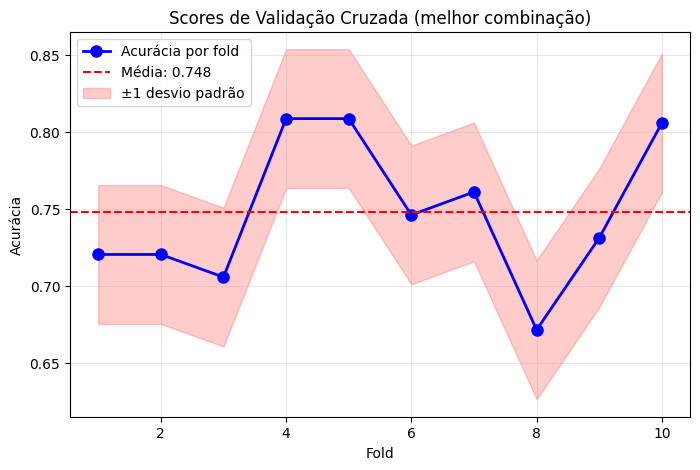

In [9]:
df = pd.DataFrame(grid_search.cv_results_)

# índice da melhor combinação de hiperparâmetros
best_idx = grid_search.best_index_

# pega os scores de cada fold para essa combinação
fold_cols = [c for c in df.columns if c.startswith("split") and c.endswith("_test_score")]
fold_scores = df.loc[best_idx, fold_cols].values.astype(float)

# calcula média e desvio padrão
mean_score = fold_scores.mean()
std_score = fold_scores.std()

# plota
plt.figure(figsize=(8,5))
plt.plot(range(1, len(fold_scores)+1), fold_scores, "bo-", linewidth=2, markersize=8, label="Acurácia por fold")

# linha da média
plt.axhline(y=mean_score, color="r", linestyle="--", label=f"Média: {mean_score:.3f}")

# faixa do desvio padrão em torno da média
plt.fill_between(range(1, len(fold_scores)+1),
                 fold_scores - std_score,
                 fold_scores + std_score,
                 alpha=0.2, color="red", label="±1 desvio padrão")

plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.title("Scores de Validação Cruzada (melhor combinação)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

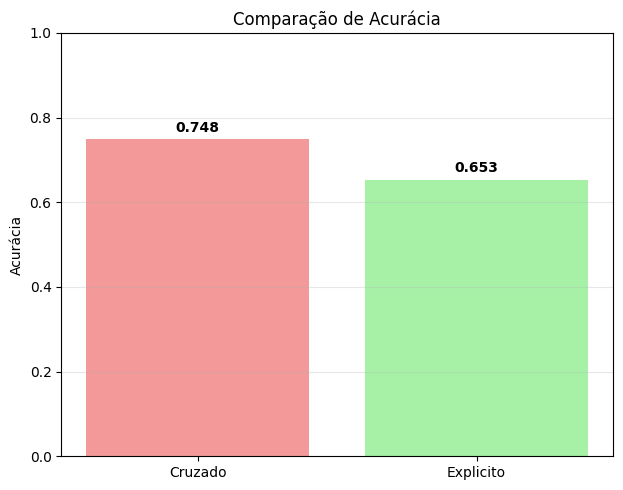

In [10]:
# Visualização da comparação de performance
plt.figure(figsize=(12, 5))

# Gráfico 1: Comparação de acurácias
plt.subplot(1, 2, 1)
models = ['Cruzado', 'Explicito']
accuracies = [grid_search.best_score_,accuracy_expl]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.ylim(0, 1)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


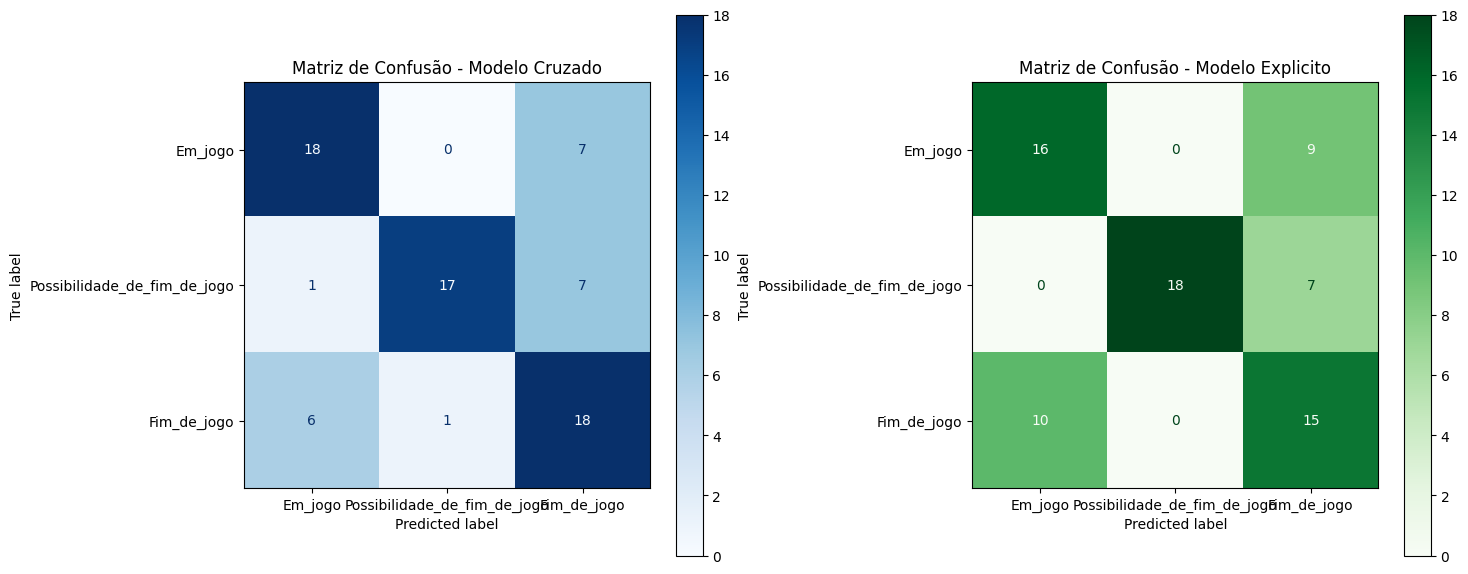

In [11]:
grid_search.best_estimator_.fit(X_tr,y_tr)

y_pred_cru = grid_search.best_estimator_.predict(X_v)

cm_cru = confusion_matrix(y_v, y_pred_cru)

# Comparação das matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz original
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_cru, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusão - Modelo Cruzado')

# Matriz otimizada
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_expl, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Matriz de Confusão - Modelo Explicito')

plt.tight_layout()
plt.show()



Teste do modelo com dataset de teste

In [12]:
rf_model = grid_search.best_estimator_

print("Treinando o modelo Random Forest...")
rf_model.fit(X_tr, y_tr)
print("Treinamento concluído!")

# Predições
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acuracia {accuracy}')

Treinando o modelo Random Forest...
Treinamento concluído!
Acuracia 0.7066666666666667


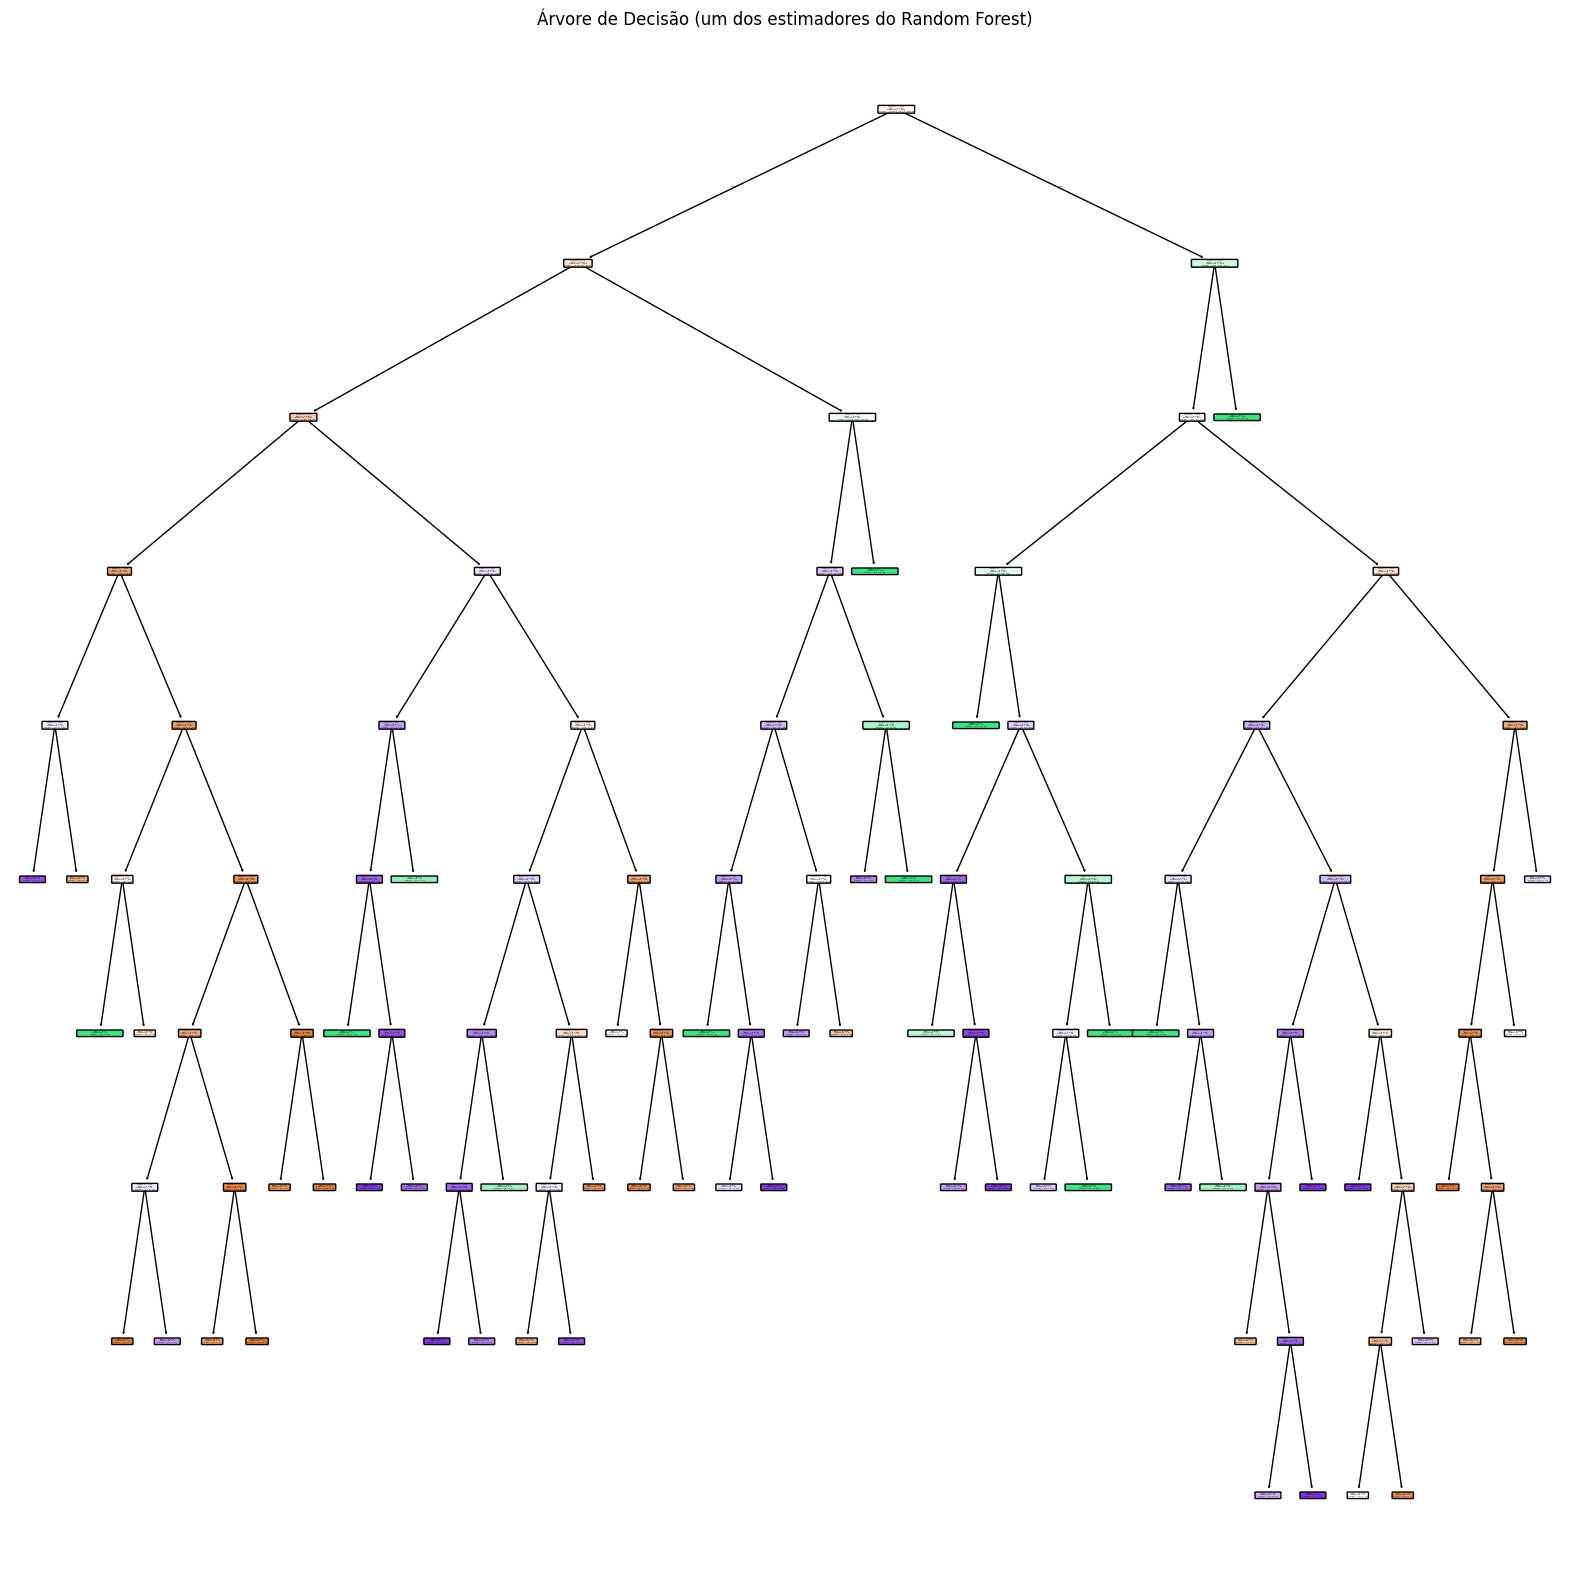

In [13]:
estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 20))
plot_tree(estimator,
          filled=True,
          rounded=True,
          feature_names=velha.drop(columns=['classe']).columns,
          class_names=['Em_jogo','Possibilidade_de_fim_de_jogo','Fim_de_jogo'])
plt.title('Árvore de Decisão (um dos estimadores do Random Forest)')
plt.show()

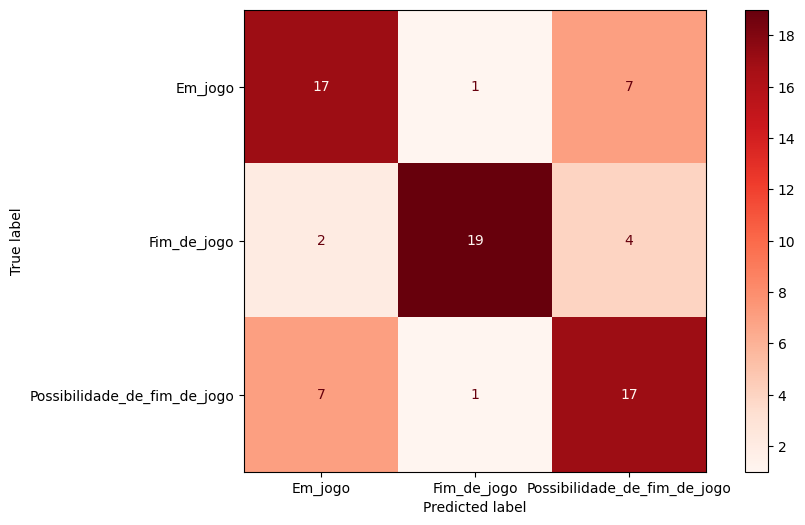

In [14]:
nomes_classes = velha.iloc[:, [9]].values
classes_unicas = np.unique(nomes_classes)

cm = confusion_matrix(y_test.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_unicas)
disp.plot(cmap='Reds')
